In [1]:
import math
import random
from typing import List, Tuple

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
test_env_name = "CartPole-v0"
test_env = gym.make(test_env_name)
state = test_env.reset()
action = test_env.action_space.sample()
next_state, reward, done, _ = test_env.step(action)
print(type(state))
print(type(action))
print(type(next_state))
print(type(reward))
print(type(done))

<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'bool'>


In [4]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [5]:
class Actor(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),            
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.net(x)
        dist = Categorical(probs)
        return dist

In [6]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),            
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        value = self.net(x)
        return value

In [23]:
class A2CAgent:
    def __init__(self, env, gamma, entropy_weight):
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight

        input_dimension = self.env.observation_space.shape
        n_actions = self.env.action_space.n
        self.actor = Actor(input_dimension, n_actions).to(device)
        self.critic = Critic(input_dimension).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.transition = list()
        self.is_test = False

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        dist = self.actor(state_tensor)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        self.transition = [state, log_prob, entropy]

        return action.cpu().detach().numpy()

    def step(self, action):
        next_state, reward, done, _ = self.env.step(action)
        self.transition.extend([next_state, reward, done])

        return next_state, reward, done

    def update_model(self):
        state, log_prob, entropy, next_state, reward, done = self.transition
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float).to(device)

        mask = 1 - done
        state_value_tensor = self.critic(state_tensor)
        next_state_value_tensor = self.critic(next_state_tensor)

        state_action_value = reward + self.gamma * next_state_value_tensor * mask
        assert state_action_value.shape == next_state_value_tensor.shape, \
            f"Wrong value shape. state action value : {state_action_value.shape}, next_state_tensor : {next_state_value_tensor.shape}"
        
        critic_loss = nn.MSELoss()(state_action_value, state_value_tensor)
        
        advantage = (state_action_value - state_value_tensor).detach()
        actor_loss = -(advantage * log_prob)
        assert advantage.shape == log_prob.unsqueeze(-1).shape, \
            f"Wrong shape. advantage : {advantage.shape}, log_prob : {log_prob.unsqueeze(-1).shape}"

        actor_loss += (self.entropy_weight * entropy)

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.actor_optimizer.step()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

    def train(self, num_frames, plotting_interval = 200):
        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            actor_loss, critic_loss = self.update_model()
            
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

            state = next_state
            score += reward

            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            self.env.render()
            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()


In [24]:
env_id = "CartPole-v0"
env = gym.make(env_id)
env.reset()

array([ 0.02812295, -0.0053905 , -0.02825683,  0.00870895])

In [25]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2
agent = A2CAgent(env, gamma, entropy_weight)

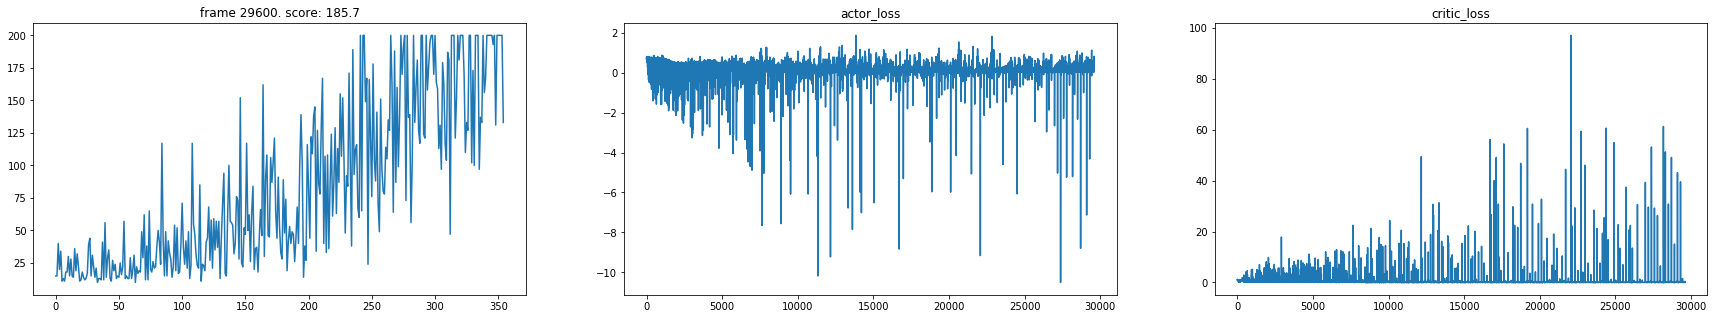

In [26]:
agent.train(num_frames)